# Exploratory data analysis

In [407]:
import pandas as pd

In [408]:
data_frame = pd.read_csv('../datasets/text.csv')

In [409]:
data_frame.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


Before spliting dataset, we need to check the distribution of the 'label' column

In [410]:
data_frame.label.value_counts()

label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64

In [411]:
del data_frame['Unnamed: 0']

In [412]:
from collections import Counter 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS
import numpy as np

In [413]:
all_labels = Counter(data_frame.label)
all_labels.most_common()

[(1, 141067), (0, 121187), (3, 57317), (4, 47712), (2, 34554), (5, 14972)]

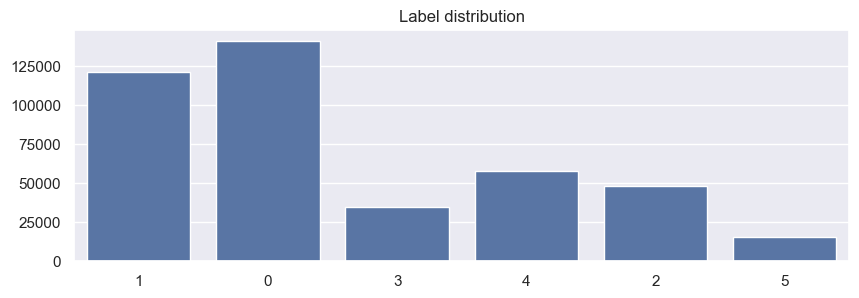

In [414]:
labels, label_counts = zip(*all_labels.most_common())
plt.figure(figsize=(10,3))
ax = sns.barplot(x=list(labels), y=list(label_counts))
ax.set_xticklabels(labels, rotation=0)
plt.title('Label distribution')
plt.show()

In [415]:
for i in range(11):
    label_0_indices = data_frame[data_frame['label'] == 0].index 
    label_1_indices = data_frame[data_frame['label'] == 1].index 

    drop_0_indices = np.random.choice(label_0_indices, size=round(len(label_0_indices)/6), replace=False)
    drop_1_indices = np.random.choice(label_1_indices, size=round(len(label_1_indices)/6), replace=False)

    new_df = data_frame.drop(index=np.concatenate([drop_0_indices, drop_1_indices]))
    data_frame = new_df

In [416]:
for i in range(10):
    label_0_indices = data_frame[data_frame['label'] == 0].index 
    label_1_indices = data_frame[data_frame['label'] == 1].index 
    label_2_indices = data_frame[data_frame['label'] == 2].index 
    label_3_indices = data_frame[data_frame['label'] == 3].index 
    label_4_indices = data_frame[data_frame['label'] == 4].index 
    label_5_indices = data_frame[data_frame['label'] == 5].index 

    drop_0_indices = np.random.choice(label_0_indices, size=round(len(label_0_indices)/8), replace=False)
    drop_1_indices = np.random.choice(label_1_indices, size=round(len(label_1_indices)/8), replace=False)
    drop_2_indices = np.random.choice(label_2_indices, size=round(len(label_2_indices)/6), replace=False)
    drop_3_indices = np.random.choice(label_3_indices, size=round(len(label_3_indices)/5), replace=False)
    drop_4_indices = np.random.choice(label_4_indices, size=round(len(label_4_indices)/5), replace=False)
    drop_5_indices = np.random.choice(label_5_indices, size=round(len(label_5_indices)/10), replace=False)

    new_df = data_frame.drop(index=np.concatenate([drop_0_indices, drop_1_indices, drop_2_indices, drop_3_indices, drop_4_indices, drop_5_indices]))
    data_frame = new_df

In [417]:
len(data_frame)

31365

In [418]:
data_frame.label.value_counts()

label
3    6155
2    5581
5    5221
4    5123
1    4994
0    4291
Name: count, dtype: int64

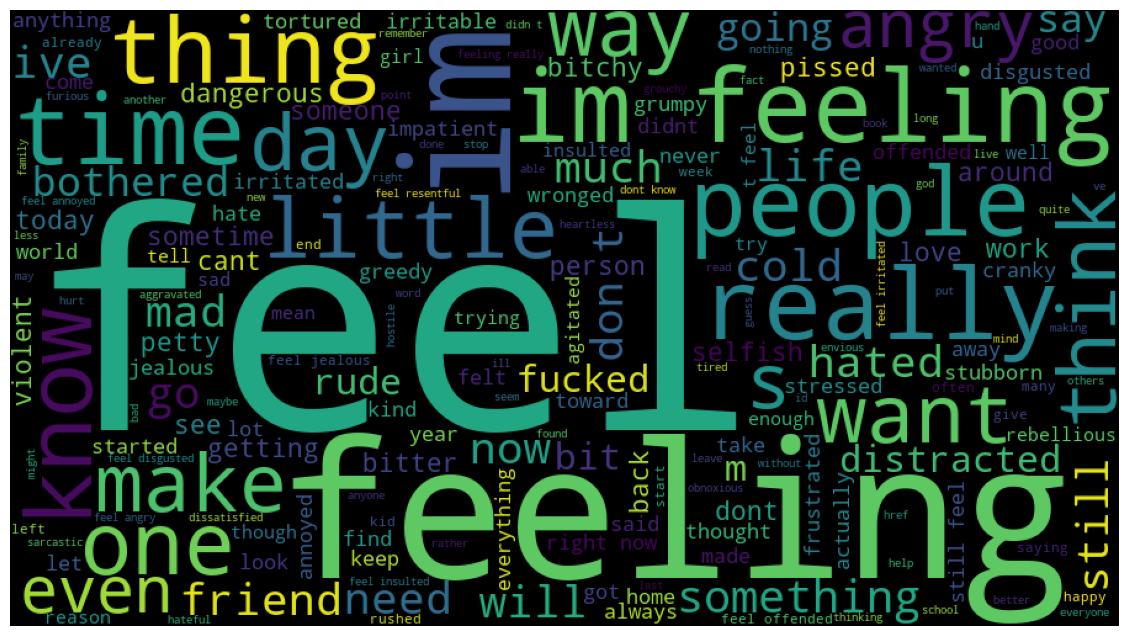

In [419]:
label = 3
plt.figure(figsize=(20,8))
subset = data_frame[data_frame.label == label]
text = subset.text.values 
cloud = WordCloud(stopwords=STOPWORDS, background_color='black', collocations=True,
                  width=900, height=500).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

# Data preprocessing

Remove null values if exist

In [420]:
data_frame.isnull().value_counts()

text   label
False  False    31365
Name: count, dtype: int64

Remove stopwords

In [421]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [422]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [423]:
STOPWORDS = stopwords.words('english')

In [424]:
def clean_text(text, stopwords=STOPWORDS):
    # Lower 
    text = text.lower()
    
    # Remove stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
    text = pattern.sub("", text)
    
    # Spacing and filters 
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)
    text = re.sub("[^A-Za-z0-9]+", " ", text)
    text = re.sub(" +", " ", text)
    text = re.sub("http\S+", "", text)
    
    return text

In [425]:
original_df = data_frame.copy()
data_frame.text = original_df.text.apply(clean_text)
data_frame.text.values[900]

'feeling rejected didnt want go home feel hollow loneliness'

Stemming

In [426]:
def stemmer(text):
    porter_stemmer = nltk.porter.PorterStemmer()
    text = ' '.join([porter_stemmer.stem(word) for word in text.split()])
    return text

In [427]:
data_frame['text'] = data_frame['text'].apply(stemmer)

In [428]:
from sklearn.model_selection import train_test_split

In [429]:
train_df, val_df = train_test_split(data_frame, 
                                    test_size=0.2, 
                                    stratify=data_frame['label'],
                                    random_state=42)

In [430]:
train_df.label.value_counts()

label
3    4924
2    4465
5    4177
4    4098
1    3995
0    3433
Name: count, dtype: int64

To check if the data splits have similar distribution, we multiply the value counts of validation_df to 4 (= train size/ validation size)

In [431]:
val_df.label.value_counts() * 4

label
3    4924
2    4464
5    4176
4    4100
1    3996
0    3432
Name: count, dtype: int64

Since the adjusted value counts of validation_df looks very similar to the value counts of train_df, these two data splits have the same class distribution

TF-IDF

In [432]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [433]:
X = train_df['text']
y = train_df['label']

In [434]:
tf = TfidfVectorizer(min_df=0.0,max_df=1.0,binary=False,ngram_range=(1,3))
tf_train = tf.fit_transform(X)

SVM

In [435]:
from sklearn.svm import SVC 
from sklearn.metrics import classification_report, confusion_matrix

In [436]:
svm = SVC(kernel='linear')
svm_model = svm.fit(tf_train, y)

In [437]:
tf_validation = tf.transform(val_df['text'])

In [438]:
y_pred = svm_model.predict(tf_validation)

In [439]:
print(classification_report(val_df['label'], y_pred))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89       858
           1       0.93      0.78      0.85       999
           2       0.83      0.95      0.88      1116
           3       0.91      0.94      0.92      1231
           4       0.91      0.84      0.87      1025
           5       0.87      0.98      0.92      1044

    accuracy                           0.89      6273
   macro avg       0.90      0.89      0.89      6273
weighted avg       0.90      0.89      0.89      6273

